#Importing Libraries


In [ ]:
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img/

#Creating a filepath

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/Datasets/autism.zip"

#Extracting the zipfile

In [ ]:
from zipfile import ZipFile

with ZipFile(filepath) as f:
  f.extractall("./autism")
  print("Data Extracted")

Data Extracted


#creating the filepath for test data and train data

In [ ]:
test_dir = "/content/autism/AutismDataset/test"
train_dir = "/content/autism/AutismDataset/train"

#Autistic and Non-Autistic train images from respective file names of train data

In [ ]:
train_non_autistic = []
train_autistic = []

for i in os.listdir(train_dir):
  if 'Non_Autistic' in ("/content/autism/AutismDataset/train/{}".format(i)):
    train_non_autistic.append(("/content/autism/AutismDataset/train/{}".format(i)))
  else:
    train_autistic.append(("/content/autism/AutismDataset/train/{}".format(i)))

# Getting test images from test data file path

In [ ]:
test_imgs = ["/content/autism/AutismDataset/test/{}".format(i) 
for i in os.listdir(test_dir)]

# Concatenate Autistic and Non-Autistic images and shuffle them as train_images

In [ ]:
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space

In [ ]:
del train_autistic
del train_non_autistic
gc.collect()

0

# Plot first 2 images from train_imgs

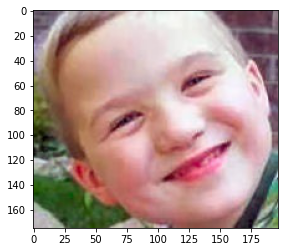

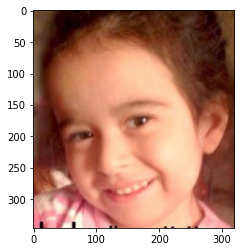

In [ ]:
import matplotlib.image as mpimg
for ima in train_imgs[0:2]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

# Dimensions for images

In [ ]:
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

In [ ]:
def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

# Get resized images and labels from train data

In [ ]:
X_train, y_train = read_and_process_image(train_imgs)

# Delete train images to save space
del train_imgs
gc.collect()

2637

# Convert the lists to array

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train image labels')

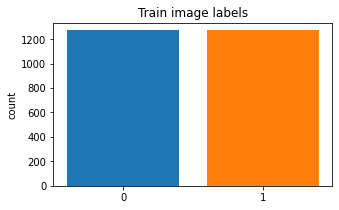

In [ ]:
plt.figure(figsize=(5, 3))
X_train = np.array(X_train)
y_train = np.array(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

# Shape of train images

In [ ]:
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


# Repeating the above process validation data to get val_images

In [ ]:
val_autistic = "/content/autism/AutismDataset/valid/Autistic"
val_non_autistic = "/content/autism/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["/content/autism/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["/content/autism/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space

In [ ]:
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

0

# Get resized images and labels from validation data

In [ ]:
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

0

# Convert the lists to array

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Validation image labels')

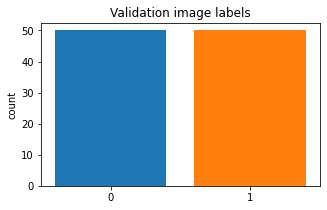

In [ ]:
plt.figure(figsize=(5, 3))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

# Shape of validation images

In [ ]:
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [ ]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [ ]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [ ]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


#Create a custom model

In [ ]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Conv2D(9,5, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(18,5, padding='same', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(36,3, padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 9)           115209    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 9)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 18)          4068      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 18)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 36)          5

In [ ]:
# Compile the model specifying optimizer, loss function and metrics
model.compile(loss = 'binary_crossentropy', 
              optimizer = keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [ ]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Create test and validation image generator
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

#Model Traning

In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=ntrain // batch_size,
                    epochs=200,
                    validation_data=val_generator,
                    validation_steps=nval // batch_size
                    )

Epoch 1/200
79/79 [==============================] - 29s 204ms/step - loss: 0.6195 - accuracy: 0.6411 - val_loss: 0.5684 - val_accuracy: 0.6667
Epoch 2/200
79/79 [==============================] - 17s 211ms/step - loss: 0.5609 - accuracy: 0.7189 - val_loss: 0.5537 - val_accuracy: 0.7083
Epoch 3/200
79/79 [==============================] - 15s 185ms/step - loss: 0.5367 - accuracy: 0.7293 - val_loss: 0.5569 - val_accuracy: 0.6875
Epoch 4/200
79/79 [==============================] - 20s 252ms/step - loss: 0.5206 - accuracy: 0.7424 - val_loss: 0.4886 - val_accuracy: 0.7708
Epoch 5/200
79/79 [==============================] - 17s 215ms/step - loss: 0.5087 - accuracy: 0.7488 - val_loss: 0.4921 - val_accuracy: 0.7396
Epoch 6/200
79/79 [==============================] - 17s 208ms/step - loss: 0.5012 - accuracy: 0.7536 - val_loss: 0.5331 - val_accuracy: 0.7292
Epoch 7/200
79/79 [==============================] - 14s 183ms/step - loss: 0.4953 - accuracy: 0.7576 - val_loss: 0.5375 - val_accuracy:

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/autism_model.h5")